In [1]:
import uproot
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import optim
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures,PowerTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from ALLSKY_energy_function import *
from getS50 import *
from draw_compare_multiply import draw_compare_multiply


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
test_size = 0.4
savepath = "./fig/energy_reconstruction/"

In [3]:
file = uproot.open("/home2/chenxu/data/gamma_all.root")


In [4]:
data = file["asresult"].arrays(["nch", "theta", "phi", "sigma", "cx", "cy", "sumpf",
                               "summd", "mr1", "ne", "age", "pritheta", "priphi", "prie", "inout"], library="np")


In [ ]:
data["cr"] = np.sqrt(data["cx"]**2+data["cy"]**2)
data["log10Energy"] = np.log10(data["prie"]/1000)
data["pritheta"] = np.rad2deg(data["pritheta"])
data["priphi"] = 180-np.rad2deg(data["priphi"])
data["priphi"][data["priphi"] > 180] = data["priphi"][data["priphi"] > 180]-360
data["S50"] = getS50(data["ne"], data["age"])
data["deltatheta"] = data["theta"]-data["pritheta"]
data["deltaphi"] = data["phi"]-data["priphi"]
data["deltaphi"][data["deltaphi"] <-200]+=360
data["deltaphi"][data["deltaphi"] >200]-=360

In [6]:
nch = data["nch"]
theta = data["theta"]
phi = data["phi"]
sigma = data["sigma"]
cx = data["cx"]
cy = data["cy"]
cr = data["cr"]
sumpf = data["sumpf"]
summd = data["summd"]
mr1 = data["mr1"]
ne = data["ne"]
age = data["age"]
pritheta = np.rad2deg(data["pritheta"])
priphi = data["priphi"]
prie = data["prie"]
inout = data["inout"]
simga=data["sigma"]
S50 = getS50(ne, age)


In [7]:
priphi = 180-np.rad2deg(priphi)
priphi[priphi>180] = priphi[priphi>180]-360

In [8]:
cuted = np.where((theta < 60) & (
    inout == 1) & (age > 0.31) & (age < 1.59) & (sigma < 1.) & (ne > 1e4))


In [9]:
nch = nch[cuted]
theta = theta[cuted]
phi = phi[cuted]
sigma = sigma[cuted]
cx = cx[cuted]
cy = cy[cuted]
sumpf = sumpf[cuted]
summd = summd[cuted]
mr1 = mr1[cuted]
ne = ne[cuted]
age = age[cuted]
pritheta = pritheta[cuted]
priphi = priphi[cuted]
prie = prie[cuted]/1000
inout = inout[cuted]
S50 = S50[cuted]
sectheta = 1/np.cos(np.deg2rad(theta))


In [10]:
train_index, test_index = train_test_split(
    range(nch.shape[0]), test_size=test_size, shuffle=True, random_state=42)


In [11]:
nch_train = nch[train_index]
theta_train = theta[train_index]
phi_train = phi[train_index]
sigma_train = sigma[train_index]
cx_train = cx[train_index]
cy_train = cy[train_index]
sumpf_train = sumpf[train_index]
summd_train = summd[train_index]
mr1_train = mr1[train_index]
ne_train = ne[train_index]
age_train = age[train_index]
pritheta_train = pritheta[train_index]
priphi_train = priphi[train_index]
prie_train = prie[train_index]
inout_train = inout[train_index]
S50_train = S50[train_index]
sectheta_train = sectheta[train_index]

nch_test = nch[test_index]
theta_test = theta[test_index]
phi_test = phi[test_index]
sigma_test = sigma[test_index]
cx_test = cx[test_index]
cy_test = cy[test_index]
sumpf_test = sumpf[test_index]
summd_test = summd[test_index]
mr1_test = mr1[test_index]
ne_test = ne[test_index]
age_test = age[test_index]
pritheta_test = pritheta[test_index]
priphi_test = priphi[test_index]
prie_test = prie[test_index]
inout_test = inout[test_index]
S50_test = S50[test_index]
sectheta_test = sectheta[test_index]


# 线性回归

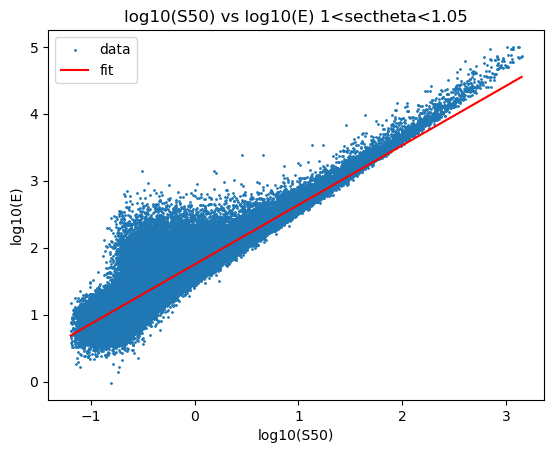

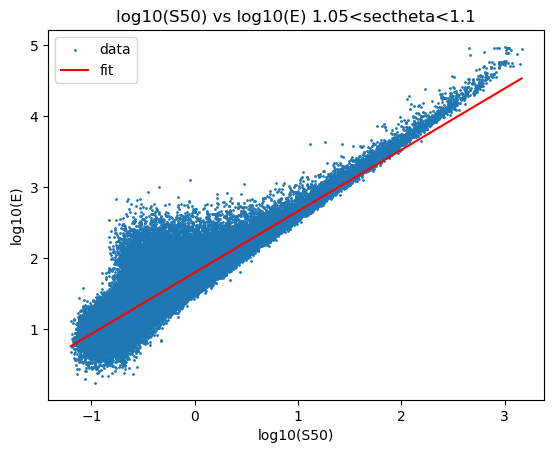

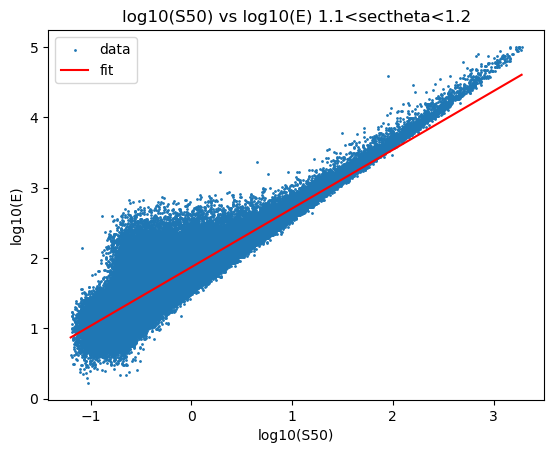

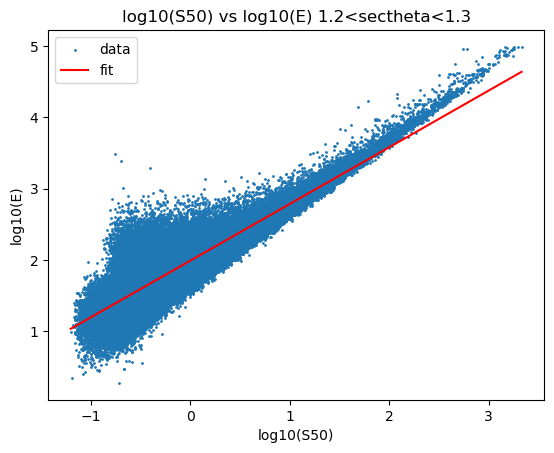

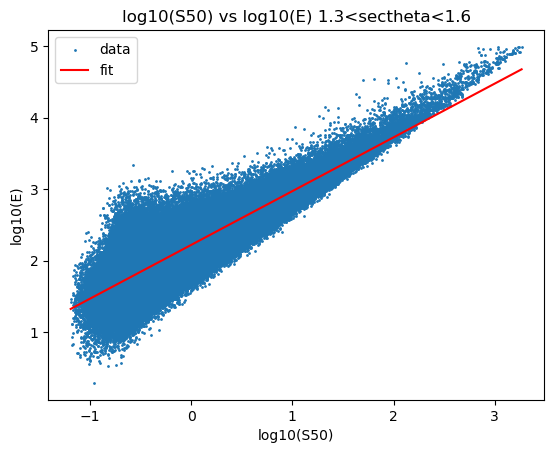

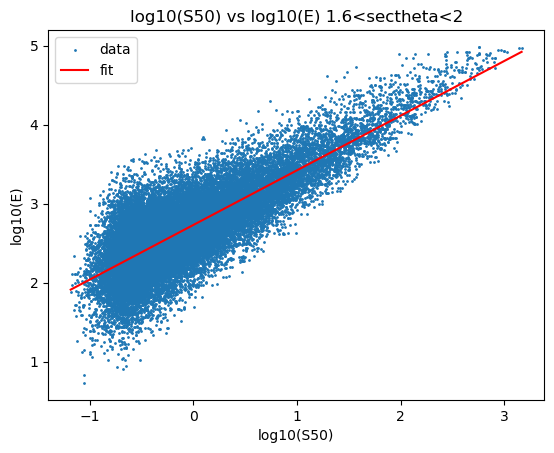

In [12]:
method = "linear_regression"
tmpsavepath = os.path.join(savepath, method)
mkdir(tmpsavepath)
sectheta_min = [1, 1.05, 1.1, 1.2, 1.3, 1.6]
sectheta_max = [1.05, 1.1, 1.2, 1.3, 1.6, 2]
energy_pred = np.zeros_like(prie_test.reshape(-1, 1))
for i in range(len(sectheta_min)):
    tmpcut_train = np.where((sectheta_train > sectheta_min[i]) & (
        sectheta_train < sectheta_max[i]))
    tmpcut_test = np.where((sectheta_test > sectheta_min[i]) & (
        sectheta_test < sectheta_max[i]))
    X = np.log10(S50_train[tmpcut_train]).reshape(-1, 1)
    y = np.log10(prie_train[tmpcut_train]).reshape(-1, 1)

    # 创建线性回归模型
    model = LinearRegression()
    model.fit(X, y)

    plt.scatter(X.reshape(-1), y.reshape(-1), label="data", s=1)
    x_plot = np.linspace(np.min(X), np.max(X), 2).reshape(-1, 1)
    plt.plot(x_plot, model.predict(x_plot), color="red", label="fit")
    plt.xlabel("log10(S50)")
    plt.ylabel("log10(E)")
    plt.title("log10(S50) vs log10(E) " +
              f"{sectheta_min[i]}<sectheta<{sectheta_max[i]}")
    plt.legend()
    mkdir(tmpsavepath)
    plt.savefig(
        f"{tmpsavepath}/S50_E_{sectheta_min[i]}<sectheta<{sectheta_max[i]}.png")
    plt.show()

    X_test = np.log10(S50_test[tmpcut_test]).reshape(-1, 1)

    energy_pred[tmpcut_test] = model.predict(X_test)
energy_orgin = prie_test.reshape(-1)
energy_pred = 10**energy_pred.reshape(-1)


<Figure size 640x480 with 0 Axes>

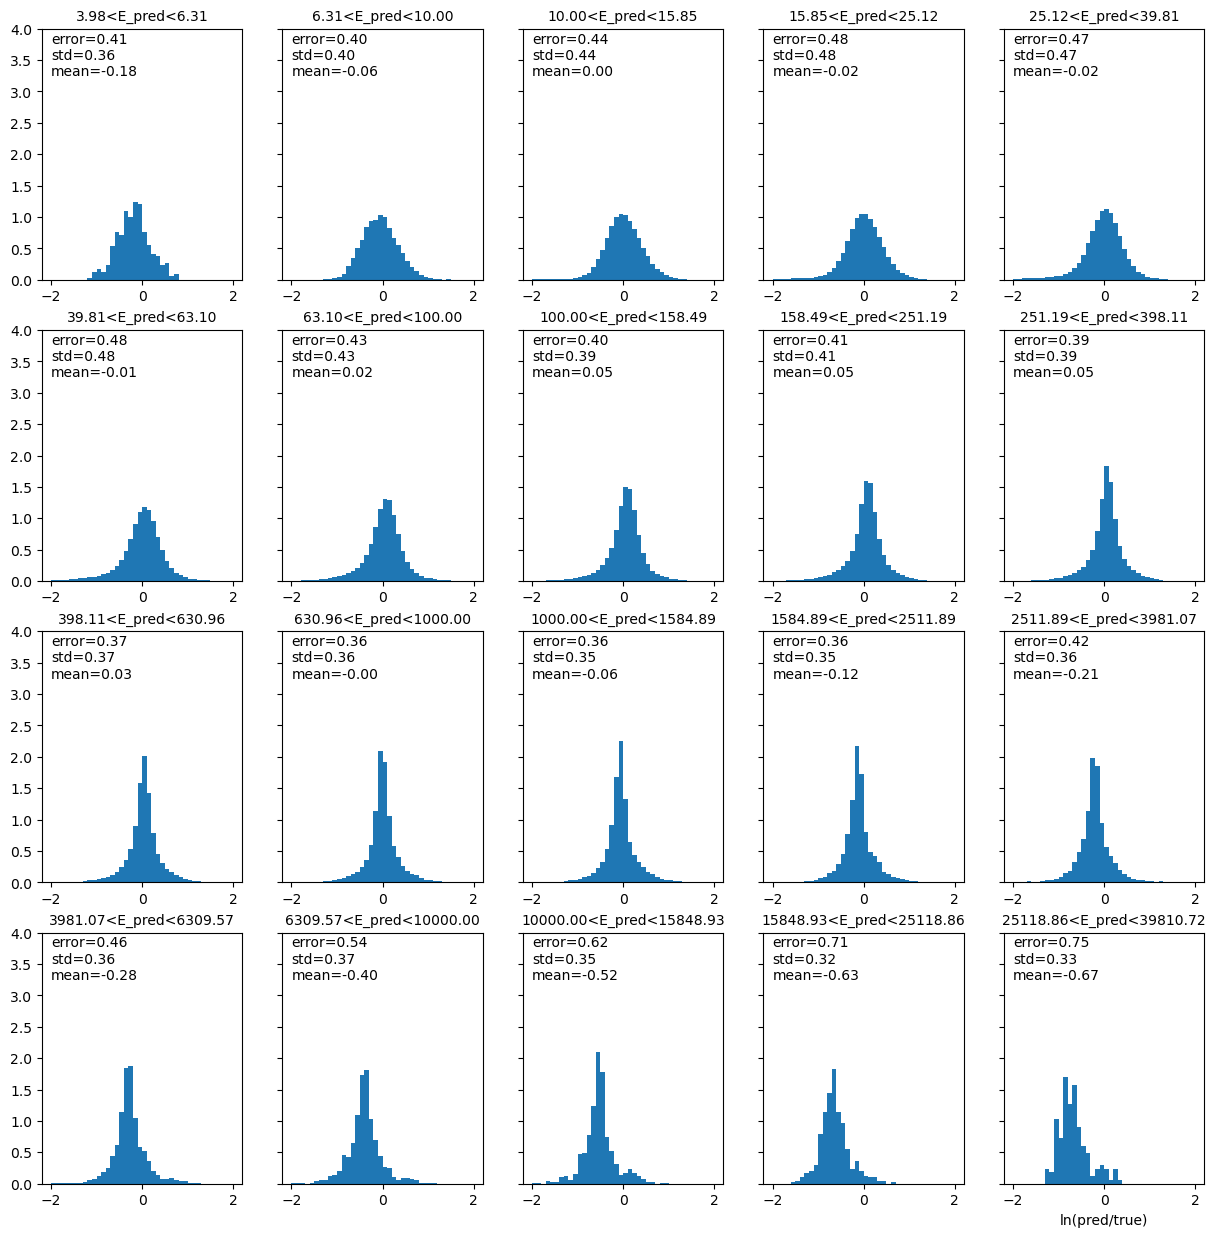

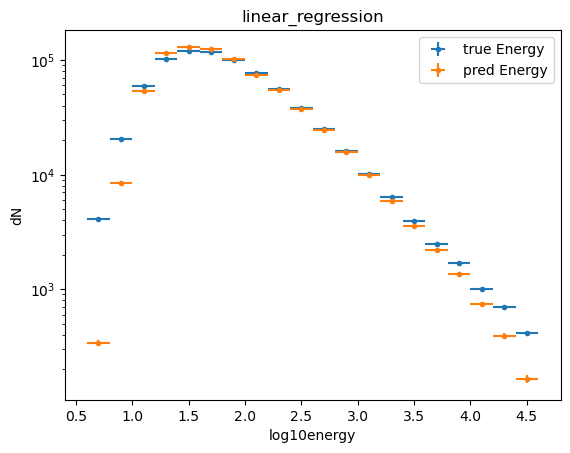

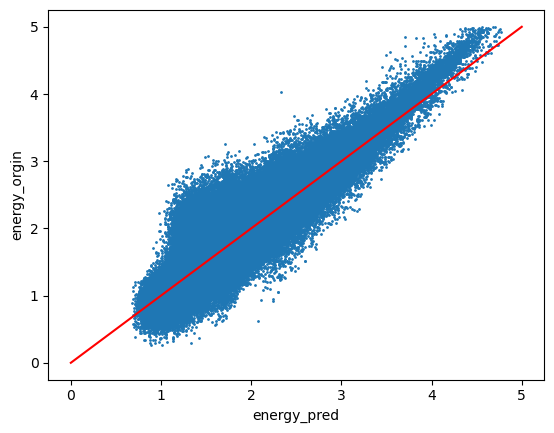

In [13]:
check_fit(energy_pred, energy_orgin, method, tmpsavepath)

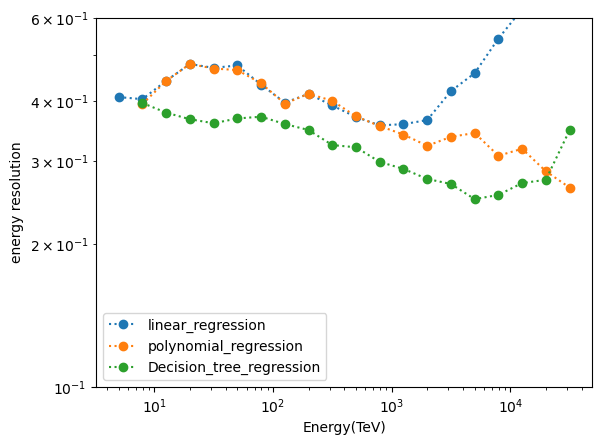

In [14]:
draw_precision()
np.save("precision_ALLSKY_sigma<1_ne>1e4.npy", precision)

# 多项式回归

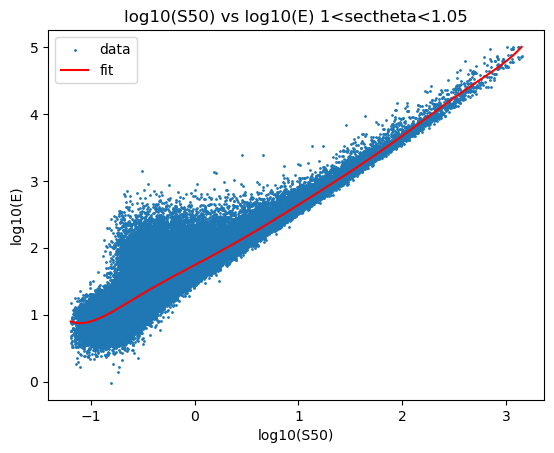

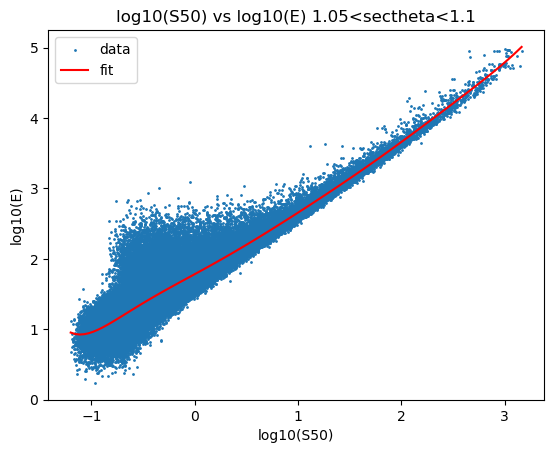

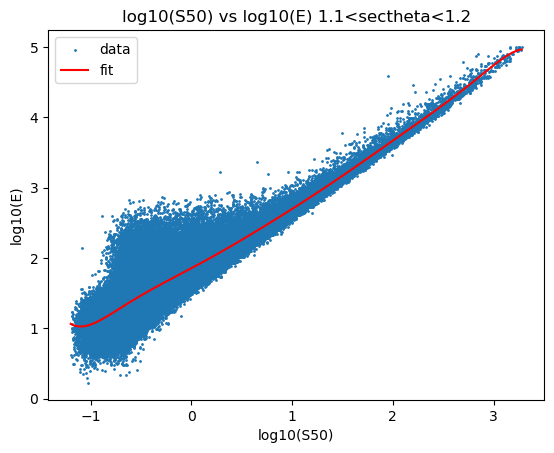

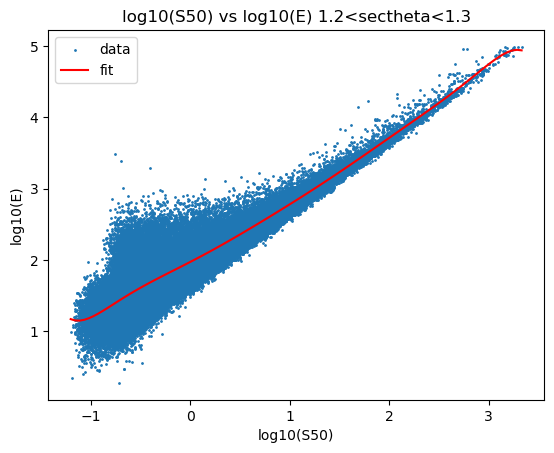

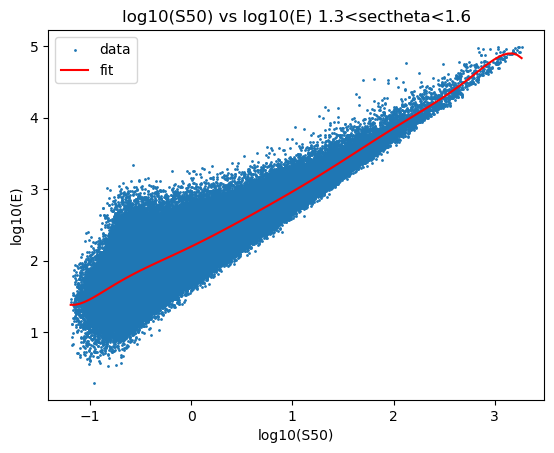

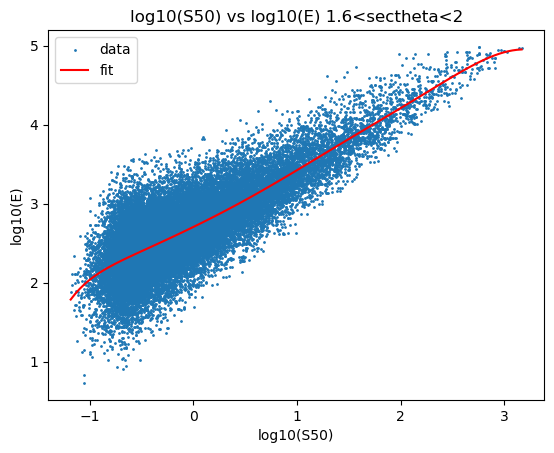

In [15]:
method = "polynomial_regression"
tmpsavepath = os.path.join(savepath, method)
mkdir(tmpsavepath)

sectheta_min = [1, 1.05, 1.1, 1.2, 1.3, 1.6]
sectheta_max = [1.05, 1.1, 1.2, 1.3, 1.6, 2]
score_max = -2
best_degree = 0
energy_pred = np.zeros_like(prie_test.reshape(-1, 1))
for i in range(len(sectheta_min)):
    tmpcut_train = np.where((sectheta_train > sectheta_min[i]) & (
        sectheta_train < sectheta_max[i]))
    tmpcut_test = np.where((sectheta_test > sectheta_min[i]) & (
        sectheta_test < sectheta_max[i]))
    X = np.log10(S50_train[tmpcut_train]).reshape(-1, 1)
    y = np.log10(prie_train[tmpcut_train]).reshape(-1, 1)
    for degree in range(1, 10):
        poly = PolynomialFeatures(degree=degree)
        X_withdegree = poly.fit_transform(X)
        # 创建线性回归模型
        model = LinearRegression()
        scores = cross_val_score(
            model, X_withdegree, y, cv=5, scoring='neg_mean_squared_error')
        # print(i, degree, scores.mean(), scores.std())

        if score_max < scores.mean():
            score_max = scores.mean()
            best_degree = degree
    poly = PolynomialFeatures(degree=best_degree)
    X_fit = poly.fit_transform(X)
    model.fit(X_fit, y)

    plt.scatter(X.reshape(-1), y.reshape(-1), label="data", s=1)
    x_plot = np.linspace(np.min(X), np.max(X), 100).reshape(-1, 1)
    x_plot_fit = poly.fit_transform(x_plot)
    plt.plot(x_plot, model.predict(x_plot_fit), color="red", label="fit")
    plt.xlabel("log10(S50)")
    plt.ylabel("log10(E)")
    plt.title("log10(S50) vs log10(E) " +
              f"{sectheta_min[i]}<sectheta<{sectheta_max[i]}")
    plt.legend()
    mkdir(tmpsavepath)
    plt.savefig(
        f"{tmpsavepath}/S50_E_{sectheta_min[i]}<sectheta<{sectheta_max[i]}.png")
    plt.show()

    X_test = np.log10(S50_test[tmpcut_test]).reshape(-1, 1)
    X_test = poly.fit_transform(X_test)
    energy_pred[tmpcut_test] = model.predict(X_test)
energy_orgin = prie_test.reshape(-1)
energy_pred = 10**energy_pred.reshape(-1)


/home2/hky/miniconda3/envs/d2l/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home2/hky/miniconda3/envs/d2l/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<Figure size 640x480 with 0 Axes>

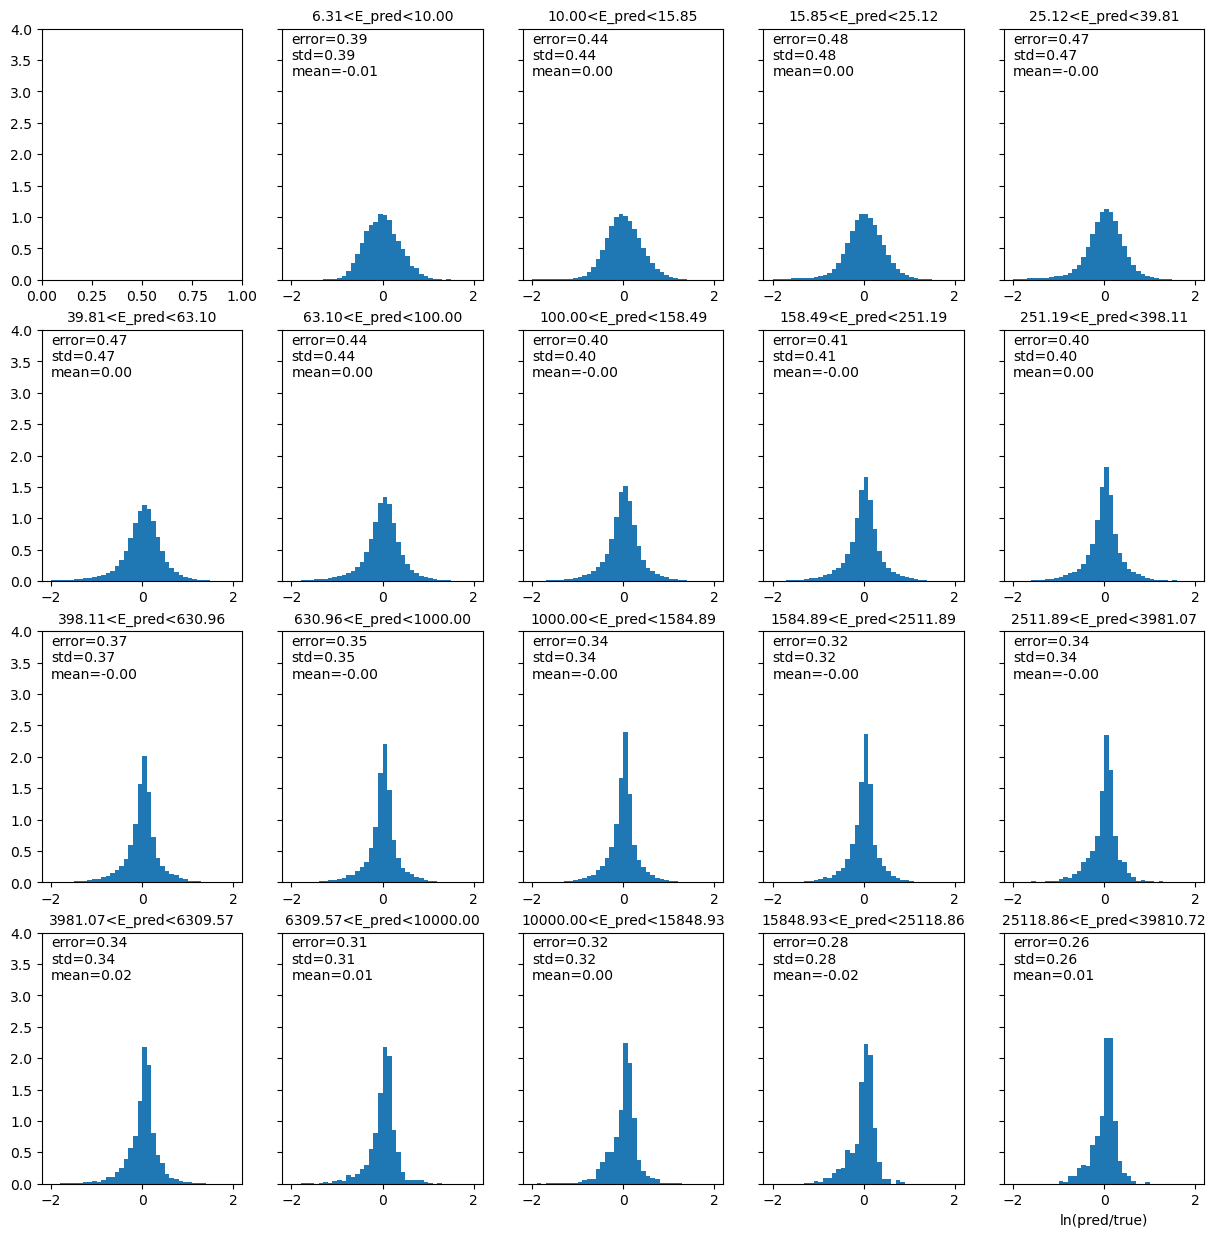

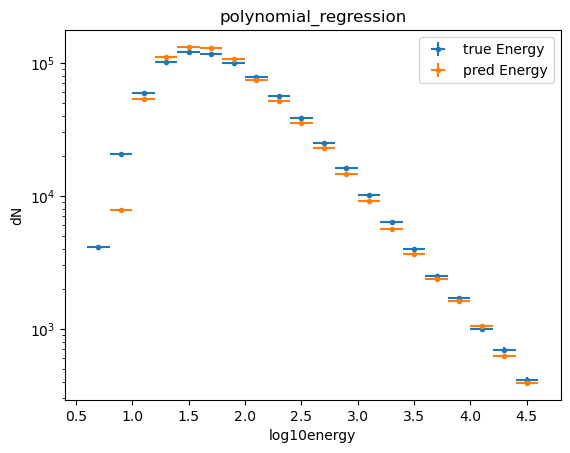

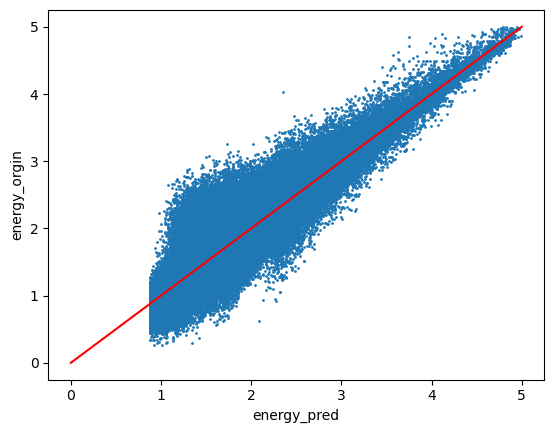

In [16]:
check_fit(energy_pred, energy_orgin, method, tmpsavepath)

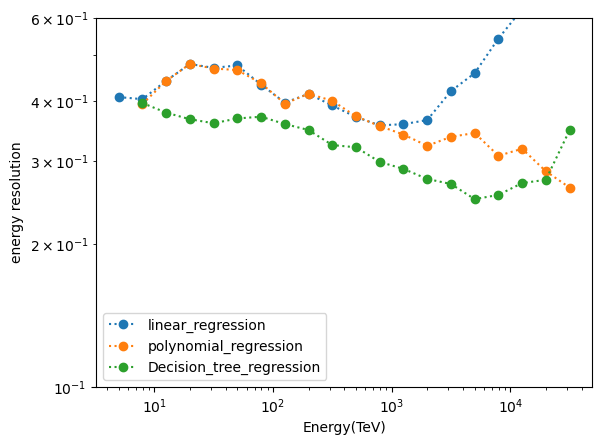

In [17]:
draw_precision()
np.save("precision_ALLSKY_sigma<1_ne>1e4.npy", precision)

# 决策树

In [19]:
method = "Decision_tree_regression"
tmpsavepath = os.path.join(savepath, method)
mkdir(tmpsavepath)
scoremax = -2
sc = PowerTransformer()
x = np.array([
    S50_train,
    sectheta_train,
    nch_train,
    sumpf_train,
    summd_train,
    mr1_train,
    ne_train,
    age_train,
    cx_train,
    cy_train,
    sigma_train,
]).T
y = np.log10(prie_train)

X = sc.fit_transform(x)

In [ ]:
for maxdepth in range(8, 15):
    # 创建决策树模型
    regr = DecisionTreeRegressor(max_depth=maxdepth)

    # 进行3则交叉验证，指定评分标准为R^2，并返回数组形式的分数
    scores = cross_val_score(
        regr, X, y, cv=5, scoring='neg_mean_squared_error')

    # 计算交叉验证的平均分数和标准差
    mean_score = scores.mean()
    std_score = scores.std()
    if scoremax < mean_score:
        scoremax = mean_score
        bestmaxdepth = maxdepth
    print(maxdepth, mean_score, std_score)
print(scoremax, bestmaxdepth)

In [20]:
bestmaxdepth=12
model = DecisionTreeRegressor(max_depth=bestmaxdepth)
model.fit(X, y)
X_test = np.array([
    S50_test,
    sectheta_test,
    nch_test,
    sumpf_test,
    summd_test,
    mr1_test,
    ne_test,
    age_test,
    cx_test,
    cy_test,
    sigma_test,
]).T
X_test = sc.transform(X_test)
energy_pred = model.predict(X_test)
energy_orgin = prie_test.reshape(-1)
energy_pred = 10**energy_pred.reshape(-1)

/home2/hky/miniconda3/envs/d2l/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home2/hky/miniconda3/envs/d2l/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<Figure size 640x480 with 0 Axes>

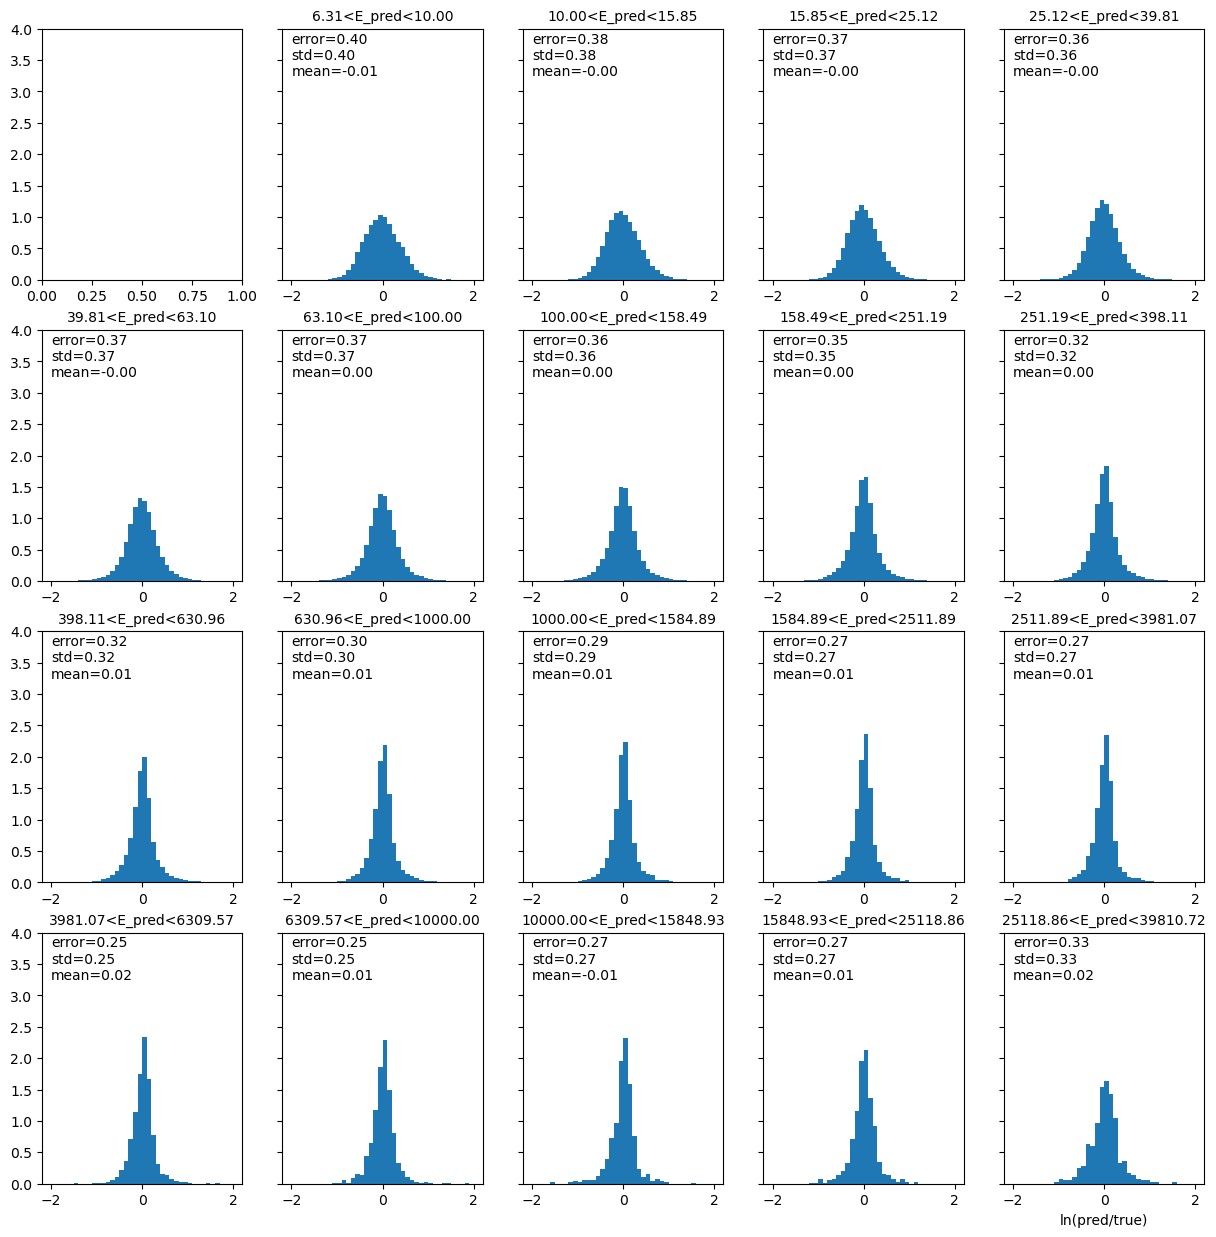

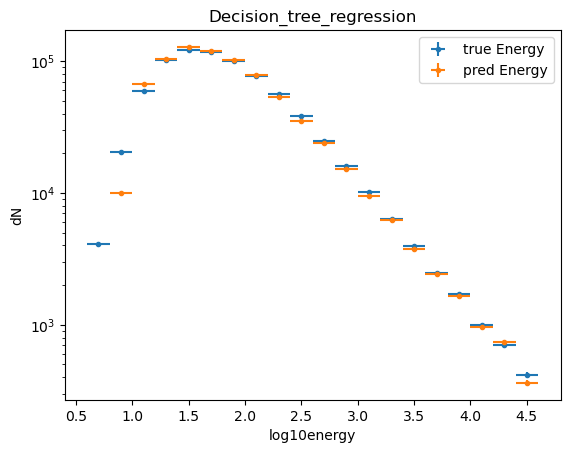

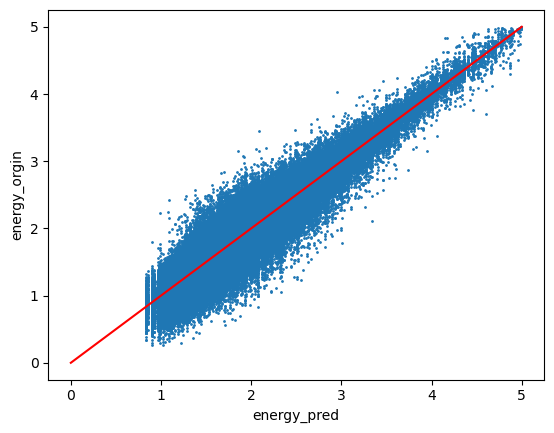

In [21]:
check_fit(energy_pred, energy_orgin, method, tmpsavepath)

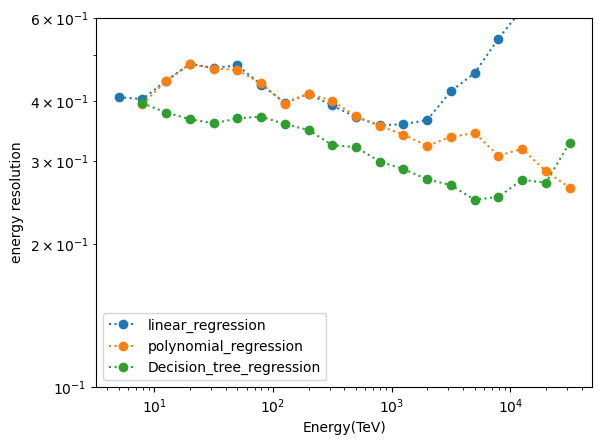

In [22]:
draw_precision()
np.save("precision_ALLSKY_sigma<1_ne>1e4.npy", precision)

# 随机森林

In [23]:
method = "Random_Forest_regression"
tmpsavepath = os.path.join(savepath, method)
mkdir(tmpsavepath)
scoremax = -2
sc = PowerTransformer()
x = np.array([
    S50_train,
    sectheta_train,
    nch_train,
    sumpf_train,
    summd_train,
    mr1_train,
    ne_train,
    age_train,
    cx_train,
    cy_train,
    sigma_train,
]).T
y = np.log10(prie_train)

X = sc.fit_transform(x)

model = RandomForestRegressor(n_estimators=100)
model.fit(X, y)
X_test = np.array([
    S50_test,
    sectheta_test,
    nch_test,
    sumpf_test,
    summd_test,
    mr1_test,
    ne_test,
    age_test,
    cx_test,
    cy_test,
    sigma_test,
]).T
X_test = sc.transform(X_test)
energy_pred = model.predict(X_test)
energy_orgin = prie_test.reshape(-1)
energy_pred = 10**energy_pred.reshape(-1)

<Figure size 640x480 with 0 Axes>

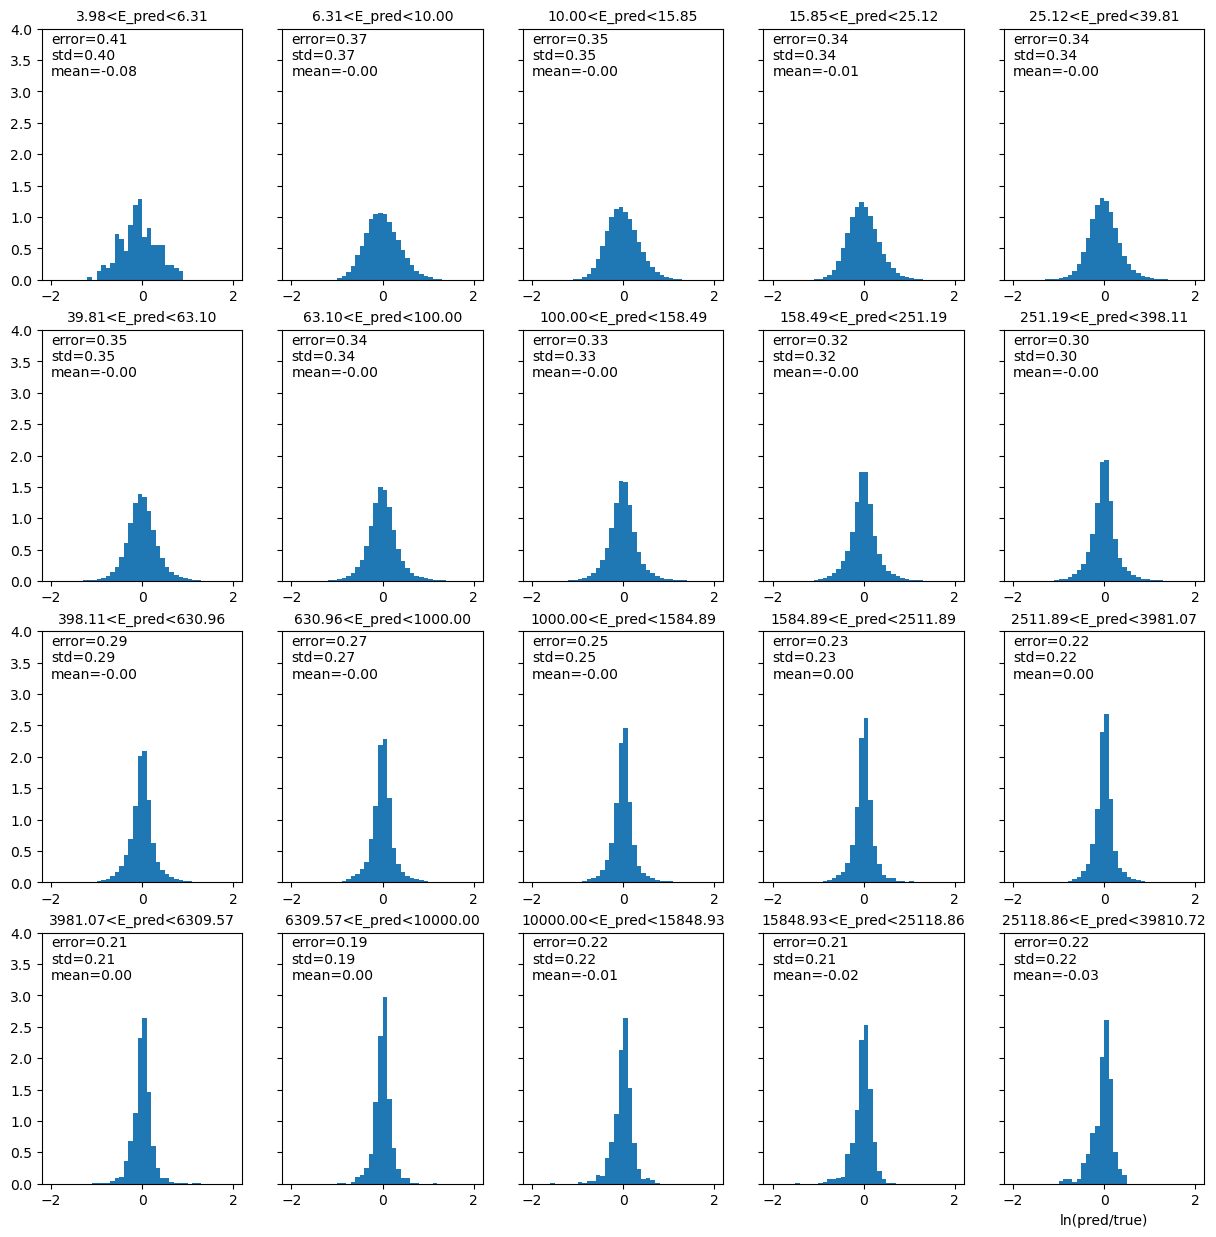

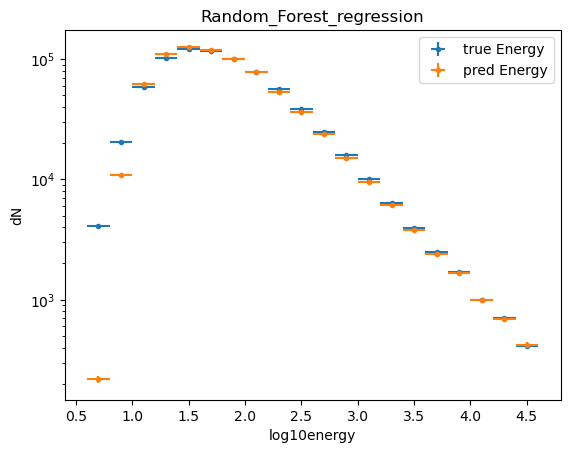

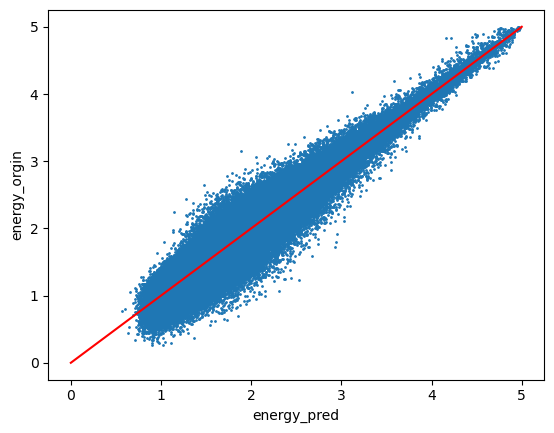

In [24]:
check_fit(energy_pred, energy_orgin, method, tmpsavepath)

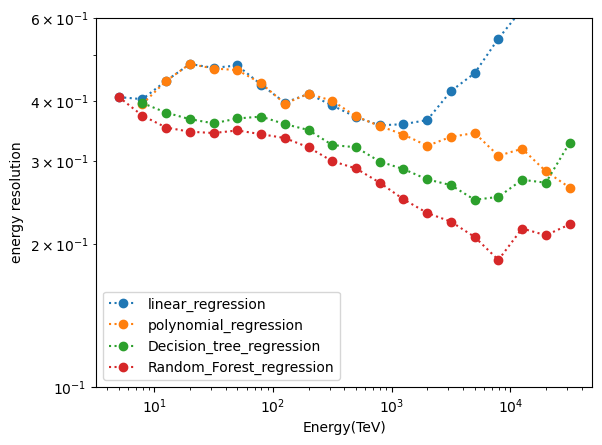

In [25]:
draw_precision()
np.save("precision_ALLSKY_sigma<1_ne>1e4.npy", precision)

# 神经网络

In [47]:
method = "Neural_Network_Regressionn"
tmpsavepath = os.path.join(savepath, method)
mkdir(tmpsavepath)


class NNmodel(torch.nn.Module):
    def __init__(self, n_in, p_dropout):
        super(NNmodel, self).__init__()
        self.layers = []
        n_hidden = 128
        while (n_hidden > 1):
            # n_in input neurons connected to i number of output neurons
            self.layers.append(nn.Linear(n_in, n_hidden))
            # Apply activation function - ReLU
            self.layers.append(nn.ReLU(inplace=True))
            # Apply batch normalization
            self.layers.append(nn.BatchNorm1d(n_hidden))
            # Apply dropout to prevent overfitting
            if n_hidden>32:
                self.layers.append(nn.Dropout(p_dropout))
            n_in = n_hidden  # Reassign number of input neurons as the number of neurons from previous last layer
            n_hidden =int(n_hidden/2)

        # Establish the FCC between the last hidden layer and output layer
        self.layers.append(nn.Linear(n_hidden*2, 1))
        self.layers = nn.Sequential(*self.layers)

    def forward(self, input):
        return self.layers(input)


In [33]:
sc = PowerTransformer()
x = np.array([
    S50_train,
    sectheta_train,
    nch_train,
    sumpf_train,
    summd_train,
    mr1_train,
    ne_train,
    age_train,
    cx_train,
    cy_train,
    sigma_train,
]).T
y = torch.from_numpy(np.log10(prie_train).reshape(-1, 1)).float()

X = torch.from_numpy(sc.fit_transform(x)).float()

loss_function = nn.MSELoss()

In [64]:
epochs = 2000
kf = KFold(n_splits=5, shuffle=True)
mean_loss_list = []
minloss = 1
for p_dropout in [0.1, 0.3, 0.5, 0.7, 0.9]:
    loss_list_min = []
    for train_index, val_index in kf.split(X):
        loss_list = []
        net = NNmodel(11, p_dropout).to(device)
        optimizer = optim.Adam(net.parameters(), lr=0.01)
        train_input = X[train_index].to(device)
        train_y = y[train_index].to(device)
        val_input = X[val_index].to(device)
        val_y = y[val_index].to(device)
        net.train()
        for epoch in range(epochs):
            outputs = net(train_input)
            optimizer.zero_grad()
            loss = loss_function(outputs, train_y)
            loss.backward()
            optimizer.step()
            net.eval()
            with torch.no_grad():
                val_outputs = net(val_input)
                val_loss = loss_function(val_outputs, val_y)
                loss_list.append(val_loss.cpu().detach().numpy())
        loss_list_min.append(np.min(loss_list))
    
    mean_loss_list.append(np.mean(loss_list_min))
    print(p_dropout, np.mean(loss_list_min),loss_list_min)
    if minloss > np.mean(loss_list_min):
        minloss = np.mean(loss_list_min)
        best_p_dropout = p_dropout


0.1 0.1974679
0.3 0.07864849
0.5 0.31609023


KeyboardInterrupt: 

In [65]:
net = NNmodel(11, 0.3).to(device)
optimizer = optim.Adam(net.parameters(), lr=0.01)
y = y.reshape(-1, 1).to(device)
epochs = 2000
x_test = np.array([S50_test, sectheta_test, nch_test, sumpf_test,
                  summd_test, mr1_test, ne_test, age_test, cx_test, cy_test, sigma_test]).T
X_test = torch.from_numpy(sc.transform(x_test)).float().to(device)
y_test = torch.from_numpy(
    np.log10(prie_test)).float().reshape(-1, 1).to(device)
train_loss_list = list()
test_loss_list = list()

for epoch in range(epochs):
    net.train()
    outputs = net(X.to(device))
    optimizer.zero_grad()
    loss = loss_function(outputs, y)
    train_loss_list.append(loss.cpu().detach().numpy())
    loss.backward()
    optimizer.step()
    net.eval()
    with torch.no_grad():
        test_input = X_test
        test_y = y_test
        test_outputs = net(test_input)
        test_loss = loss_function(test_outputs, test_y)
        test_loss_list.append(test_loss.cpu().numpy())
    if (epoch+1) % 200 == 0:
        print(epoch+1, loss.cpu().detach().numpy(), test_loss.cpu().numpy())


200 0.026319614 0.022378385
400 0.024224363 0.021685926
600 0.023377113 0.021249318
800 0.022846516 0.020929145
1000 0.022441288 0.020887965
1200 0.022146614 0.020881427
1400 0.021942658 0.021100432
1600 0.021708898 0.021261878
1800 0.021690711 0.022095678
2000 0.021542775 0.021916395


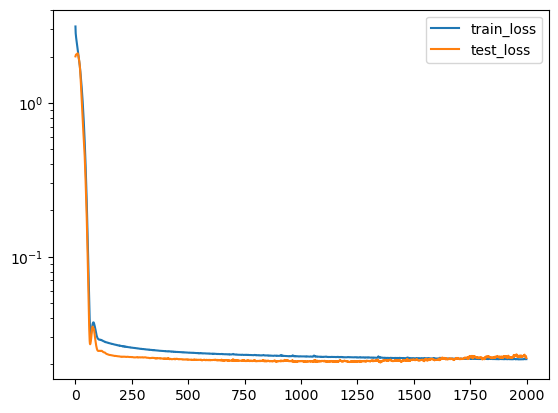

In [66]:
plt.plot(range(len(train_loss_list)),train_loss_list,label="train_loss")
plt.plot(range(len(test_loss_list)),test_loss_list,label="test_loss")
plt.yscale("log")
plt.legend()
plt.show()

In [71]:
energy_orgin = prie_test.reshape(-1)
energy_pred = 10**test_outputs.cpu().numpy().reshape(-1)

/home2/hky/miniconda3/envs/d2l/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home2/hky/miniconda3/envs/d2l/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<Figure size 640x480 with 0 Axes>

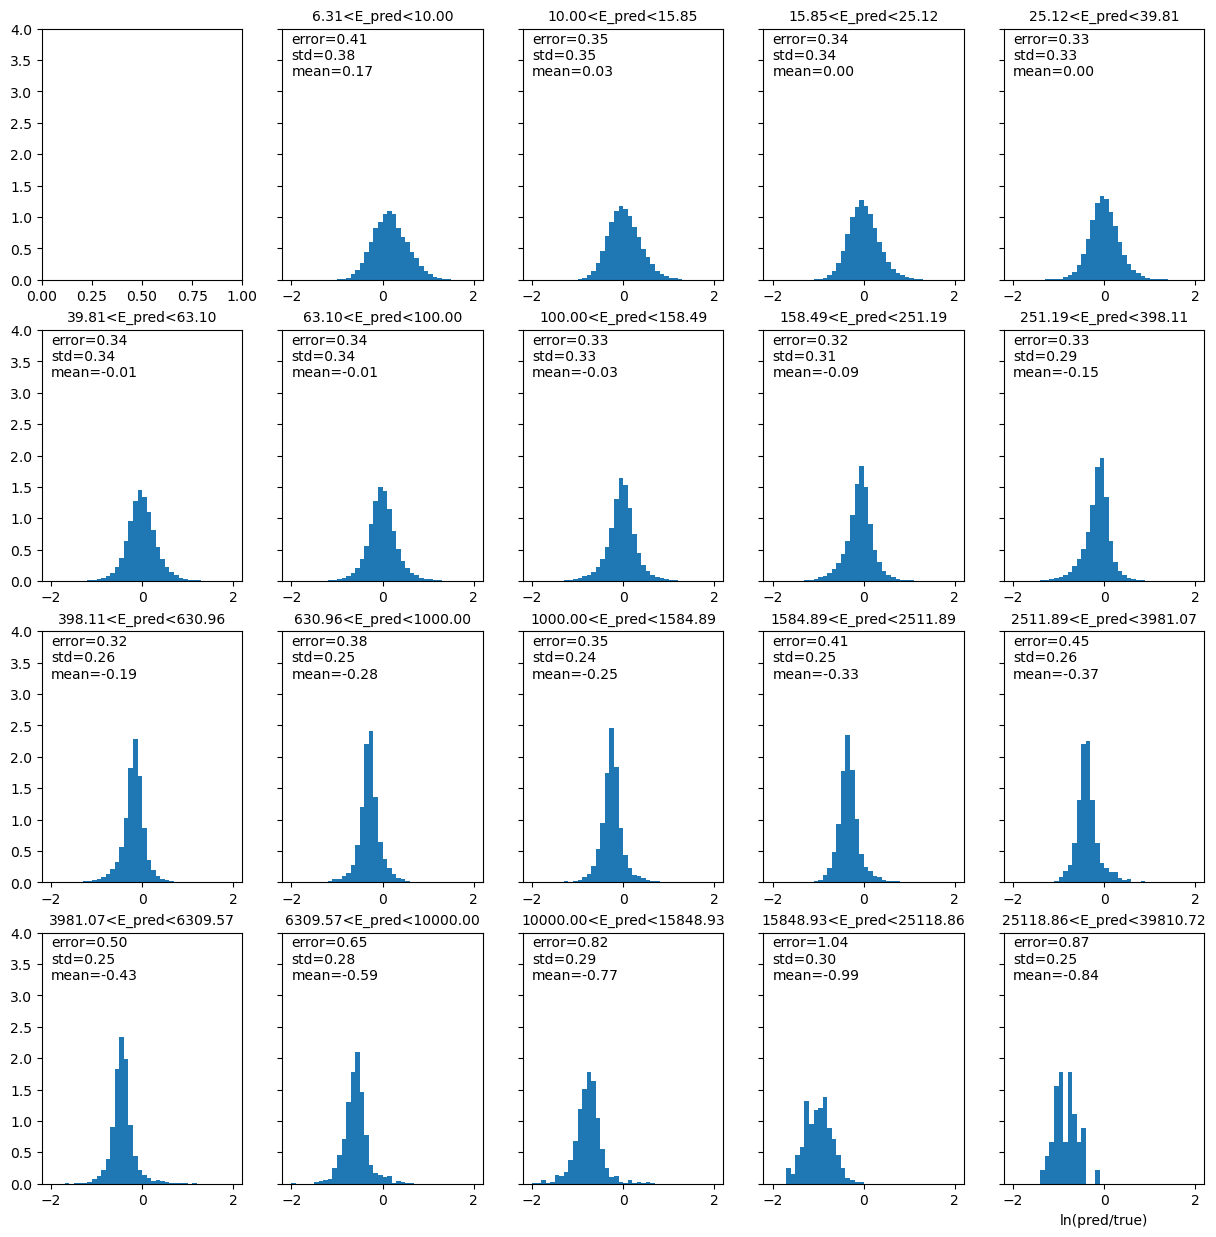

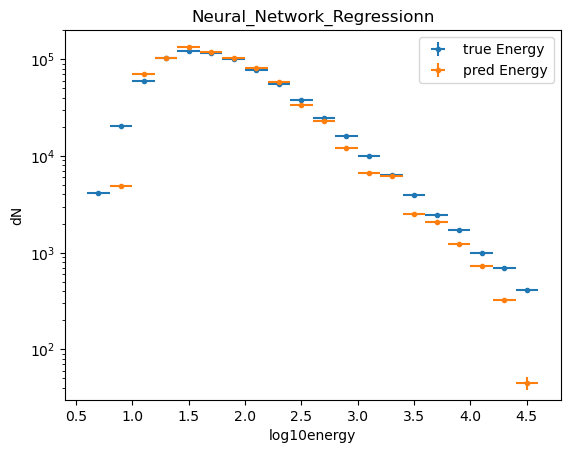

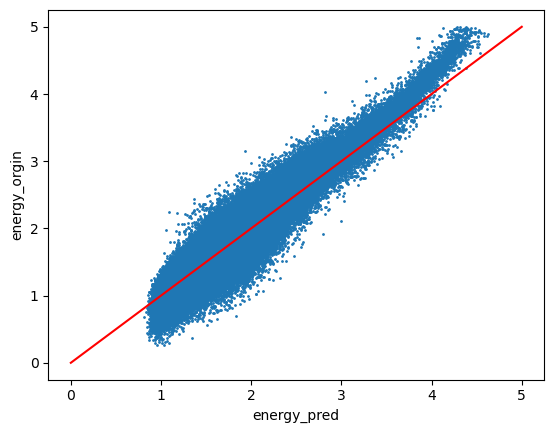

In [72]:
check_fit(energy_pred, energy_orgin, method, tmpsavepath)

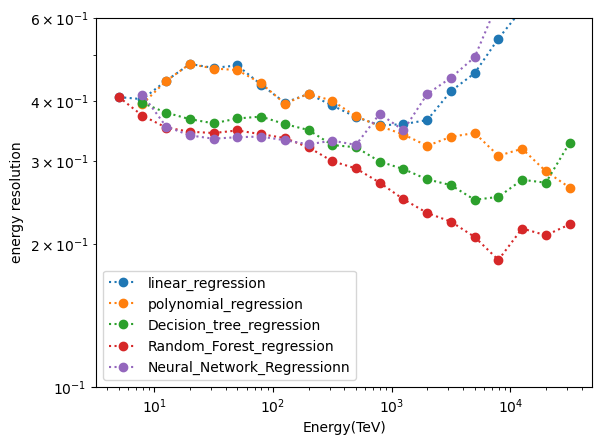

In [73]:
draw_precision()
np.save("precision_ALLSKY_sigma<1_ne>1e4.npy", precision)

# autogluon

In [8]:
from autogluon.tabular import TabularDataset, TabularPredictor
predictor = TabularPredictor.load("/home2/hky/github/Gamma_Energy/AllSky/AutogluonModels/ag-20230327_173915")

In [9]:
results = predictor.fit_summary(show_plot=True)

*** Summary of fit() ***
Estimated performance of each model:
                          model  score_val  pred_time_val      fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           WeightedEnsemble_L3  -0.147451    7528.977551  23830.999727                0.017433          12.843076            3      False         22
1          ExtraTreesMSE_BAG_L2  -0.147589    6944.592044  15685.512442               39.565693          98.140263            2      False         17
2        NeuralNetFastAI_BAG_L2  -0.147605    6949.325627  21718.276954               44.299275        6130.904774            2      False         18
3          LightGBMLarge_BAG_L2  -0.147685    6925.742640  15811.422069               20.716288         224.049889            2      False         21
4               LightGBM_BAG_L2  -0.147697    6927.627165  15788.908210               22.600813         201.536031            2      False         14
5                XGBoost_BAG_L2  -0.14

/home2/hky/miniconda3/envs/d2l/lib/python3.9/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


In [10]:
test_data_autogluon = TabularDataset(
    "/home2/hky/github/Gamma_Energy/AllSky/MC_test_AllSky_Data_transformed.csv")
energy_pred = 10**predictor.predict(test_data_autogluon.drop(
    columns=["log_energy"])).to_numpy()

/home2/hky/miniconda3/envs/d2l/lib/python3.9/site-packages/catboost/core.py:1222: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,


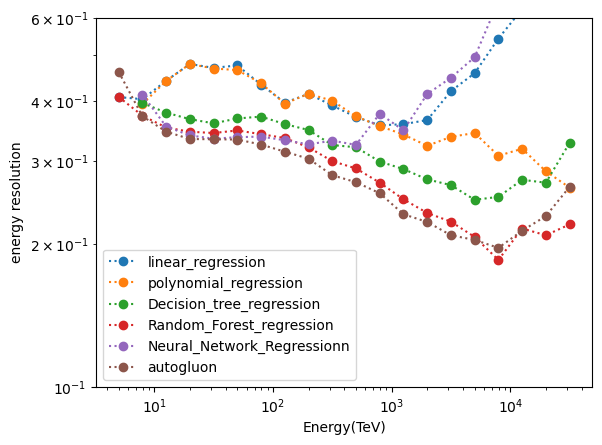

In [2]:
draw_precision()
np.save("precision_ALLSKY_sigma<1.npy", precision)

In [22]:
parameter_list = ["nch", "theta", "phi", "sigma", "cx", "cy", "cr", "sumpf",
                  "summd", "mr1", "ne", "age", "pritheta", "priphi", "prie", "inout"]
for para in parameter_list:
    datalist = [data[para][cuted][test_index][np.where(np.abs(np.log10(energy_pred/prie_test))<0.2)], data[para][cuted][test_index][np.where(np.abs(np.log10(energy_pred/prie_test))>=0.2)]]
    legendlist = ["normal", "bad"]
    for binsnumber in [10, 20, 30, 40]:
        for if_logx in [0, 1]:
            for if_logy in [0, 1]:
                draw_compare_multiply(datalist, legendlist, paraname=para,
                                      bins_number=binsnumber, if_logx=if_logx, if_logy=if_logy, savepath=f"/home2/hky/github/Gamma_Energy/AllSky/fig/checkbadfit/{para}", savename=f"{para}_{binsnumber}_{if_logx}_{if_logy}.png")


nch_10_0_0.png
nch_10_0_1.png
nch_10_1_0.png
nch_10_1_1.png
nch_20_0_0.png
nch_20_0_1.png
nch_20_1_0.png
nch_20_1_1.png
nch_30_0_0.png
nch_30_0_1.png
nch_30_1_0.png
nch_30_1_1.png
nch_40_0_0.png
nch_40_0_1.png
nch_40_1_0.png
nch_40_1_1.png
theta_10_0_0.png
theta_10_0_1.png
theta_10_1_0.png
theta_10_1_1.png
theta_20_0_0.png
theta_20_0_1.png
theta_20_1_0.png
theta_20_1_1.png
theta_30_0_0.png
theta_30_0_1.png
theta_30_1_0.png
theta_30_1_1.png
theta_40_0_0.png
theta_40_0_1.png
theta_40_1_0.png
theta_40_1_1.png
phi_10_0_0.png
phi_10_0_1.png
phi_20_0_0.png
phi_20_0_1.png
phi_30_0_0.png
phi_30_0_1.png
phi_40_0_0.png
phi_40_0_1.png
sigma_10_0_0.png
sigma_10_0_1.png
sigma_10_1_0.png
sigma_10_1_1.png
sigma_20_0_0.png
sigma_20_0_1.png
sigma_20_1_0.png
sigma_20_1_1.png
sigma_30_0_0.png
sigma_30_0_1.png
sigma_30_1_0.png
sigma_30_1_1.png
sigma_40_0_0.png
sigma_40_0_1.png
sigma_40_1_0.png
sigma_40_1_1.png
cx_10_0_0.png
cx_10_0_1.png
cx_20_0_0.png
cx_20_0_1.png
cx_30_0_0.png
cx_30_0_1.png
cx_40_0_0.pn